In [1]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import sklearn.linear_model
import os.path

import time

from NeuralNet import NeuralNet
from utils.json import read_from_json
from utils.nnsetup import get_datasets
from attacks.attacks import Attack

np.random.seed(1)

In [2]:
X_train, Y_train, Y_train_e, X_test, Y_test = get_datasets()

In [3]:
cls = NeuralNet(layer_dims = [784, 60, 10], learning_rate = 0.1, num_iter = 300, \
                         normalize = False, mini_batch_size=2048)

cls.parameters = read_from_json("nets/main_nn_300")

In [4]:
cls_dist = NeuralNet(layer_dims = [784, 60, 10], learning_rate = 0.1, num_iter = 300, \
                         normalize = False, mini_batch_size=2048)

cls_dist.parameters = read_from_json("nets/distilled_nn_300")

In [5]:
X_test_c = X_test[:300].copy()
Y_test_c = Y_test[:300].copy()

In [6]:
def L2_norm(x, axis=0):
  return np.sqrt(np.square(x).sum(axis=axis))

In [81]:
def get_insights(classifier, X_test_c=X_test_c, Y_test_c=Y_test_c, ignore_not_adversarial=False, show_progress=True):
  attack = Attack(classifier)

  df = pd.DataFrame(columns = ['target','successful attempts', 'epsilon']) #'initial',
  non_targeted = pd.DataFrame(columns = ['original','prediction','iterations', 'epsilon', 'L2 norm'])

  Y_hat_c = classifier.predict(X_test_c)

  tick = time.time()
  for epsilon in [1/255]:#np.arange(50)/255:#, 3/255, 5/255, 10/255, 15/255, 30/255, 50/255, 80/255, 120/255]:#[1/255]:#0.007, 0.01, 0.05, 0.1, 0.2]:
      print('epsilon =',epsilon)
      total_attempts = 0
      total_iter = 0
      example = []
      initial = []
      true_label = []
      adversarial = []
      y_hat_adv = []

      for (x, y, y_hat) in zip(X_test_c, Y_test_c, Y_hat_c):
          x = np.array([x])
          prediction = y_hat

          if(not ignore_not_adversarial or y == y_hat):
        
              x_adv = attack.attack(x,\
                                    np.array([[1 if i==y else 0 for i in range(10)]]),\
                                    #'ADAM',\
                                    'FGSM',\
                                    #'grads',\
                                    5,\
                                    #pretrub_importance=0.01,\
                                    adapting_rate=epsilon, print_cost=False, targeted=False).T[0]
              
              total_iter += attack.iter

              example.append(x_adv)
              true_label.append([y])

              total_attempts += 1
              #print(classifier.predict(np.array([x_adv])))
              prediction = classifier.predict(np.array([x_adv]))[0]
              if(prediction != y):
                  initial.append(x[0])
                  adversarial.append(x_adv)
                  
                  non_targeted = non_targeted.append({'original': y[0],'prediction': prediction,\
                                  'iterations': attack.iter, 'L2 norm': L2_norm(x[0]-x_adv),\
                                  'epsilon': epsilon}, ignore_index=True)
                  
          y_hat_adv.append(prediction)
          
          if(show_progress and total_attempts% 50 == 0): print(total_attempts,'instances,', len(adversarial), 'adversaries');

      example = np.array(example)
      initial = np.array(initial)
      true_label = np.array(true_label)
      adversarial = np.array(adversarial)
      y_hat_adv = np.array(y_hat_adv)

      print('------------------------------',example.shape)
      Y_hat = classifier.predict(example).reshape(true_label.shape)

      #print((Y_hat == target).shape)
      #print((Y_hat != Y_test) * (Y_hat == target) * ((cls.predict(X_test)==Y_test).reshape(Y_hat.shape)))

      successful_attempts = len(adversarial)#np.sum(
      #  (Y_hat != true_label)
      #  * (Y_hat == target))
        #* (true_label == cls.predict(X_test_c).reshape(true_label.shape)))

      df = df.append({'successful attempts': successful_attempts, 'epsilon': epsilon}, ignore_index=True)

  print('total time:', time.time() - tick)
  print('total iter:', total_iter)
  return df, non_targeted

In [82]:
df, insights = get_insights(cls)
df

epsilon = 0.00392156862745098
50 instances, 5 adversaries
100 instances, 8 adversaries
150 instances, 10 adversaries
200 instances, 13 adversaries
250 instances, 14 adversaries
300 instances, 21 adversaries
------------------------------ (300, 784)
total time: 1.9039440155029297
total iter: 1160


,target,successful attempts,epsilon
0,NaN,21.0,0.003922


In [83]:
insights.head()

,original,prediction,iterations,epsilon,L2 norm
0,9.0,4.0,3.0,0.003922,0.245372
1,4.0,9.0,4.0,0.003922,0.341109
2,4.0,7.0,4.0,0.003922,0.440038
3,8.0,6.0,0.0,0.003922,0.000000
4,4.0,3.0,1.0,0.003922,0.089940


In [84]:
insights[insights['L2 norm'] > 0]

,original,prediction,iterations,epsilon,L2 norm
0,9.0,4.0,3.0,0.003922,0.245372
1,4.0,9.0,4.0,0.003922,0.341109
2,4.0,7.0,4.0,0.003922,0.440038
4,4.0,3.0,1.0,0.003922,0.089940
9,6.0,8.0,2.0,0.003922,0.178464
10,4.0,7.0,4.0,0.003922,0.342526
11,8.0,0.0,3.0,0.003922,0.247836
12,6.0,5.0,2.0,0.003922,0.179195
13,4.0,9.0,4.0,0.003922,0.328968
14,2.0,8.0,4.0,0.003922,0.404283


In [60]:
# pretrub_by_iter = non_targeted.groupby('iterations', as_index=False)['L2 norm'].mean()
# pretrub_by_iter = pretrub_by_iter.sort_values("iterations")

# plt.plot(pretrub_by_iter['iterations'], pretrub_by_iter['L2 norm'])

In [61]:
# accuracy_t = []
# for iter in pretrub_by_iter["iterations"].values:
#     accuracy_t.append(1 - non_targeted[non_targeted["iterations"]<=iter].shape[0]/total_attempts)
    
# iterations_t = pretrub_by_iter["iterations"].values

In [62]:
# FGSM_t, = plt.plot(iterations_t, accuracy_t, 'g-', label='TFGSM')

In [63]:
df_dist, insights_dist = get_insights(cls_dist)
df

epsilon = 0.0
50 instances, 3 adversaries
100 instances, 7 adversaries
150 instances, 8 adversaries
200 instances, 10 adversaries
250 instances, 10 adversaries
300 instances, 16 adversaries
------------------------------ (300, 784)
epsilon = 0.00392156862745098
50 instances, 4 adversaries
100 instances, 8 adversaries
150 instances, 9 adversaries
200 instances, 11 adversaries
250 instances, 11 adversaries
300 instances, 18 adversaries
------------------------------ (300, 784)
epsilon = 0.00784313725490196
50 instances, 5 adversaries
100 instances, 9 adversaries
150 instances, 10 adversaries
200 instances, 12 adversaries
250 instances, 12 adversaries
300 instances, 19 adversaries
------------------------------ (300, 784)
epsilon = 0.011764705882352941
50 instances, 8 adversaries
100 instances, 12 adversaries
150 instances, 13 adversaries
200 instances, 16 adversaries
250 instances, 16 adversaries
300 instances, 25 adversaries
------------------------------ (300, 784)
epsilon = 0.01568627

250 instances, 204 adversaries
300 instances, 243 adversaries
------------------------------ (300, 784)
epsilon = 0.12941176470588237
50 instances, 43 adversaries
100 instances, 85 adversaries
150 instances, 125 adversaries
200 instances, 170 adversaries
250 instances, 208 adversaries
300 instances, 248 adversaries
------------------------------ (300, 784)
epsilon = 0.13333333333333333
50 instances, 43 adversaries
100 instances, 86 adversaries
150 instances, 127 adversaries
200 instances, 172 adversaries
250 instances, 210 adversaries
300 instances, 250 adversaries
------------------------------ (300, 784)
epsilon = 0.13725490196078433
50 instances, 44 adversaries
100 instances, 87 adversaries
150 instances, 130 adversaries
200 instances, 175 adversaries
250 instances, 214 adversaries
300 instances, 255 adversaries
------------------------------ (300, 784)
epsilon = 0.1411764705882353
50 instances, 45 adversaries
100 instances, 88 adversaries
150 instances, 131 adversaries
200 instance

,target,successful attempts,epsilon
0,NaN,7.0,0.000000
1,NaN,8.0,0.003922
2,NaN,11.0,0.007843
3,NaN,14.0,0.011765
4,NaN,19.0,0.015686
5,NaN,21.0,0.019608
6,NaN,27.0,0.023529
7,NaN,35.0,0.027451
8,NaN,40.0,0.031373
9,NaN,49.0,0.035294


In [64]:
insights_dist.head()

,original,prediction,iterations,epsilon,L2 norm
0,2.0,3.0,0.0,0.0,0.0
1,8.0,6.0,0.0,0.0,0.0
2,4.0,9.0,0.0,0.0,0.0
3,4.0,9.0,0.0,0.0,0.0
4,6.0,4.0,0.0,0.0,0.0


In [65]:
n_iter = max(max(insights['iterations']), max(insights_dist['iterations']))
n_iter

0.0

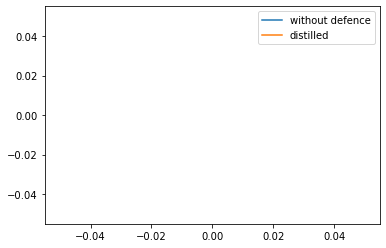

In [68]:
iterations = np.arange(n_iter)

accuracy = []
accuracy_dist = []
for i in iterations:
  accuracy.append(1 - sum(insights['iterations']<=i)/Y_test_c.shape[0])
  accuracy_dist.append(1 - sum(insights_dist['iterations']<=i)/Y_test_c.shape[0])
  
plt.plot(iterations, accuracy, label='without defence')
plt.plot(iterations, accuracy_dist, label='distilled')
plt.legend()
plt.show()

In [69]:
epsilons = np.arange(50)/255

accuracy = []
accuracy_dist = []
for e in iterations:
  accuracy.append(1 - sum(insights['epsilon']<=e)/Y_test_c.shape[0])
  accuracy_dist.append(1 - sum(insights_dist['epsilon']<=e)/Y_test_c.shape[0])
  
plt.plot(epsilon, accuracy, label='without defence')
plt.plot(epsilons, accuracy_dist, label='distilled')
plt.legend()
plt.show()

NameError: name 'epsilon' is not defined

Something wrong. Probably algorithm stop condition is uncorrect. Also will be nice to extract samples with initially incorrect classification.

In [18]:
Y_train_hat = cls.predict(X_train)
Y_test_hat = cls.predict(X_test)

print(accuracy_score(Y_train, Y_train_hat))
print(accuracy_score(Y_test, Y_test_hat))

0.9714583333333333
0.9571428571428572


In [19]:
Y_train_hat = cls_dist.predict(X_train)
Y_test_hat = cls_dist.predict(X_test)

print(accuracy_score(Y_train, Y_train_hat))
print(accuracy_score(Y_test, Y_test_hat))

0.9462202380952381
0.9396428571428571
